### Load the graph as created by GPT


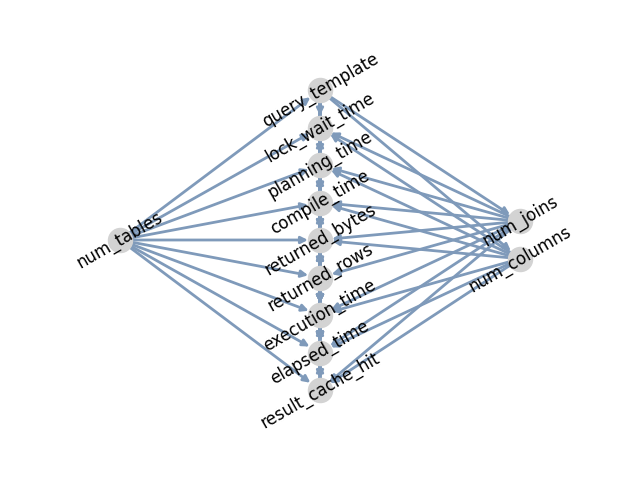

In [49]:
import pickle 
import sys
sys.path.append('../')
from scripts.graph_renderer import GraphRenderer

filepath = '/home/markakis/tpc-ds-postgres-queries/causal-discovery/2024-07-03 17:36:14.157556-sys_query_history_preprocessed.pkl_gpt_gpt-4_acyclic.pkl'

with open(filepath, 'rb') as f:
    graph = pickle.load(f)

GraphRenderer.display_graph(graph, {})

In [50]:
len(graph.edges)

55

### Generate a summary using CaGreS


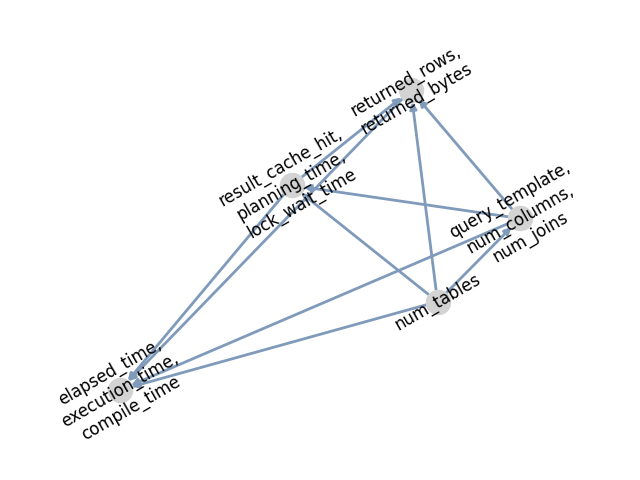

Nodes
	num*tables
	query*template_num*columns_num*joins
	result*cache*hit_planning*time_lock*wait*time
	returned*rows_returned*bytes
	elapsed*time_execution*time_compile*time
Edges:
	('num*tables', 'result*cache*hit_planning*time_lock*wait*time')
	('num*tables', 'elapsed*time_execution*time_compile*time')
	('num*tables', 'returned*rows_returned*bytes')
	('num*tables', 'query*template_num*columns_num*joins')
	('query*template_num*columns_num*joins', 'result*cache*hit_planning*time_lock*wait*time')
	('query*template_num*columns_num*joins', 'elapsed*time_execution*time_compile*time')
	('query*template_num*columns_num*joins', 'returned*rows_returned*bytes')
	('result*cache*hit_planning*time_lock*wait*time', 'elapsed*time_execution*time_compile*time')
	('result*cache*hit_planning*time_lock*wait*time', 'returned*rows_returned*bytes')
	('returned*rows_returned*bytes', 'elapsed*time_execution*time_compile*time')


In [60]:
sys.path.append('/home/markakis/CausalDAGSummarization')
from Utils import get_recursive_basis
from Greedy import greedy, get_cost
import networkx as nx
import numpy as np
import pandas as pd
from itertools import combinations


d = {x: x.replace("_", "*") for x in list(graph.nodes)}
relabeled_graph = nx.relabel_nodes(graph, d)
k = 5
nodes = list(relabeled_graph.nodes)
recursive_basis = get_recursive_basis(relabeled_graph, nodes)
similarity_df = pd.DataFrame(np.ones((len(nodes), len(nodes))), index=nodes, columns=nodes)
summary_dag_greedy, recursive_basis_greedy = greedy(relabeled_graph, nodes, recursive_basis, k, similarity_df)
vars_dict = {x: x.replace("_", ",\n").replace("*", "_") for x in list(summary_dag_greedy.nodes)}
GraphRenderer.display_graph(summary_dag_greedy, vars_dict, layout='spring')
topo_sort = list(nx.topological_sort(summary_dag_greedy))
print(f"Nodes")
for node in topo_sort:
    print(f"\t{node}")
print(f"Edges:")
for node in topo_sort:
    for edge in summary_dag_greedy.out_edges(node):
        print(f"\t{edge}") 

Edge ('result\*cache\*hit_planning\*time_lock\*wait\*time', 'returned\*rows_returned\*bytes') seems suspicious. Let's see the corresponding ground-truth graph edges.

In [59]:
interesting_nodes = ['returned_rows', 'returned_bytes']
for node in interesting_nodes:  
    for edge in graph.in_edges(node):
        print(edge)

('lock_wait_time', 'returned_rows')
('query_template', 'returned_rows')
('num_tables', 'returned_rows')
('num_joins', 'returned_rows')
('result_cache_hit', 'returned_bytes')
('returned_rows', 'returned_bytes')
('lock_wait_time', 'returned_bytes')
('query_template', 'returned_bytes')
('num_tables', 'returned_bytes')
('num_columns', 'returned_bytes')
('num_joins', 'returned_bytes')


### Revise graph and generate new summary

In [61]:
revised_graph = graph.copy()
edges_to_remove = [('lock_wait_time', 'returned_rows'), ('lock_wait_time', 'returned_bytes'), ('result_cache_hit', 'returned_bytes')]
revised_graph.remove_edges_from(edges_to_remove)


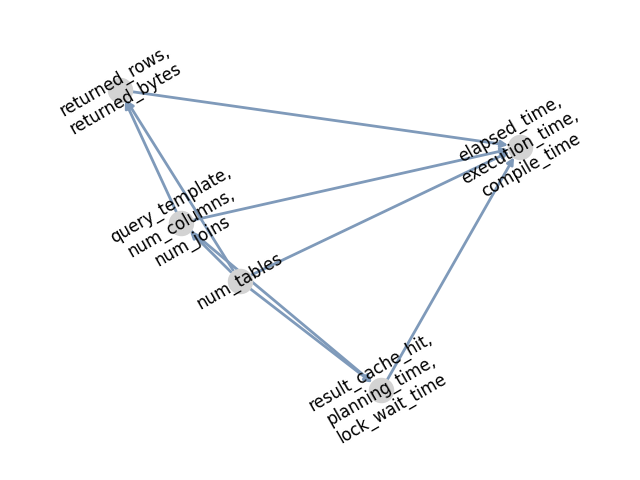

Nodes
	num*tables
	query*template_num*columns_num*joins
	result*cache*hit_planning*time_lock*wait*time
	returned*rows_returned*bytes
	elapsed*time_execution*time_compile*time
Edges:
	('num*tables', 'result*cache*hit_planning*time_lock*wait*time')
	('num*tables', 'elapsed*time_execution*time_compile*time')
	('num*tables', 'returned*rows_returned*bytes')
	('num*tables', 'query*template_num*columns_num*joins')
	('query*template_num*columns_num*joins', 'result*cache*hit_planning*time_lock*wait*time')
	('query*template_num*columns_num*joins', 'elapsed*time_execution*time_compile*time')
	('query*template_num*columns_num*joins', 'returned*rows_returned*bytes')
	('result*cache*hit_planning*time_lock*wait*time', 'elapsed*time_execution*time_compile*time')
	('returned*rows_returned*bytes', 'elapsed*time_execution*time_compile*time')


In [62]:
d = {x: x.replace("_", "*") for x in list(revised_graph.nodes)}
revised_relabeled_graph = nx.relabel_nodes(revised_graph, d)
k = 5
nodes = list(revised_relabeled_graph.nodes)
recursive_basis = get_recursive_basis(revised_relabeled_graph, nodes)
similarity_df = pd.DataFrame(np.ones((len(nodes), len(nodes))), index=nodes, columns=nodes)
revised_summary_dag_greedy, recursive_basis_greedy = greedy(revised_relabeled_graph, nodes, recursive_basis, k, similarity_df)
vars_dict = {x: x.replace("_", ",\n").replace("*", "_") for x in list(revised_summary_dag_greedy.nodes)}
GraphRenderer.display_graph(revised_summary_dag_greedy, vars_dict, layout='spring')
topo_sort = list(nx.topological_sort(revised_summary_dag_greedy))
print(f"Nodes")
for node in topo_sort:
    print(f"\t{node}")
print(f"Edges:")
for node in topo_sort:
    for edge in revised_summary_dag_greedy.out_edges(node):
        print(f"\t{edge}") 